# Feedforward SNN on MNIST (snnTorch)

This notebook runs the existing scripts in this repo to provide inline outputs and figures.

- Baseline: Poisson-encoded MNIST → LIF hidden layer → spike-count readout
- Tweaks: Homeostasis, Tau sweep, Sparse connectivity

Note: Ensure the environment is set up as per `commands.txt` and GPU is available.

### About this cell: Environment and paths

- Adds project root `'.'` to `sys.path` so imports like `from scripts.baseline import run_baseline` work.
- Checks for CUDA availability; scripts will use GPU if available.
- Requires environment setup from `commands.txt` (PyTorch CUDA wheels, snnTorch, sklearn, etc.).

In [ ]:
# Path and environment checks
import os, sys
sys.path.append('.')  # allow 'src' and 'scripts' imports
import torch, snntorch, sklearn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

## Utility to display saved figures

### About this cell: Figure utilities

- Provides `show_if_exists(path)` helper to render saved images inline.
- Sets standard paths: `figures/`, `outputs/`, `.data/`.
- Scripts save figures and reports to these folders; this helper displays them after runs.

In [ ]:
from IPython.display import display, Image
def show_if_exists(path):
    if os.path.exists(path):
        display(Image(filename=path))
    else:
        print(f'Not found: {path}')
FIG_DIR = 'figures'
OUT_DIR = 'outputs'
DATA_DIR = '.data'

## Baseline

In [ ]:
from types import SimpleNamespace
from scripts.baseline import run_baseline
# Configure baseline args (same defaults as script)
args = SimpleNamespace(
    data_dir=DATA_DIR, output_dir=OUT_DIR, fig_dir=FIG_DIR,
    batch_size=128, num_workers=2, hidden=512, tau_ms=20.0, dt_ms=1.0, t_ref_ms=2.0, v_th=1.0,
    num_steps=100, fmax_hz=100.0, w_mean=0.5, w_std=0.1, readout='logreg',
    # improved readout defaults
    scale_features=True, max_iter=1000, solver='lbfgs', C=1.0, penalty='none',
    seed=42
)
run_baseline(args)
print('Baseline done. Showing figures:')
show_if_exists(os.path.join(FIG_DIR, 'baseline_initial_filters.png'))
show_if_exists(os.path.join(FIG_DIR, 'baseline_raster.png'))
show_if_exists(os.path.join(FIG_DIR, 'baseline_voltage.png'))
print('Report:');
print(open(os.path.join(OUT_DIR, 'baseline_report.txt')).read())

```bash
(snncogs) aryas@3b676eb3826b:~/work/snn$  PYTHONPATH=. python scripts/baseline.py \
   --hidden 1024 --tau_ms 20 --dt_ms 1 --t_ref_ms 2 \
   --num_steps 100 --fmax_hz 100 --batch_size 128 \
   --readout logreg --max_iter 2000 --solver lbfgs --penalty none --C 1.0 \
   --data_dir .data --output_dir outputs --fig_dir figures --num_workers 4
Device: cuda
train feature extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.74it/s]
test feature extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.40it/s]
Baseline Test Accuracy: 0.1156
```

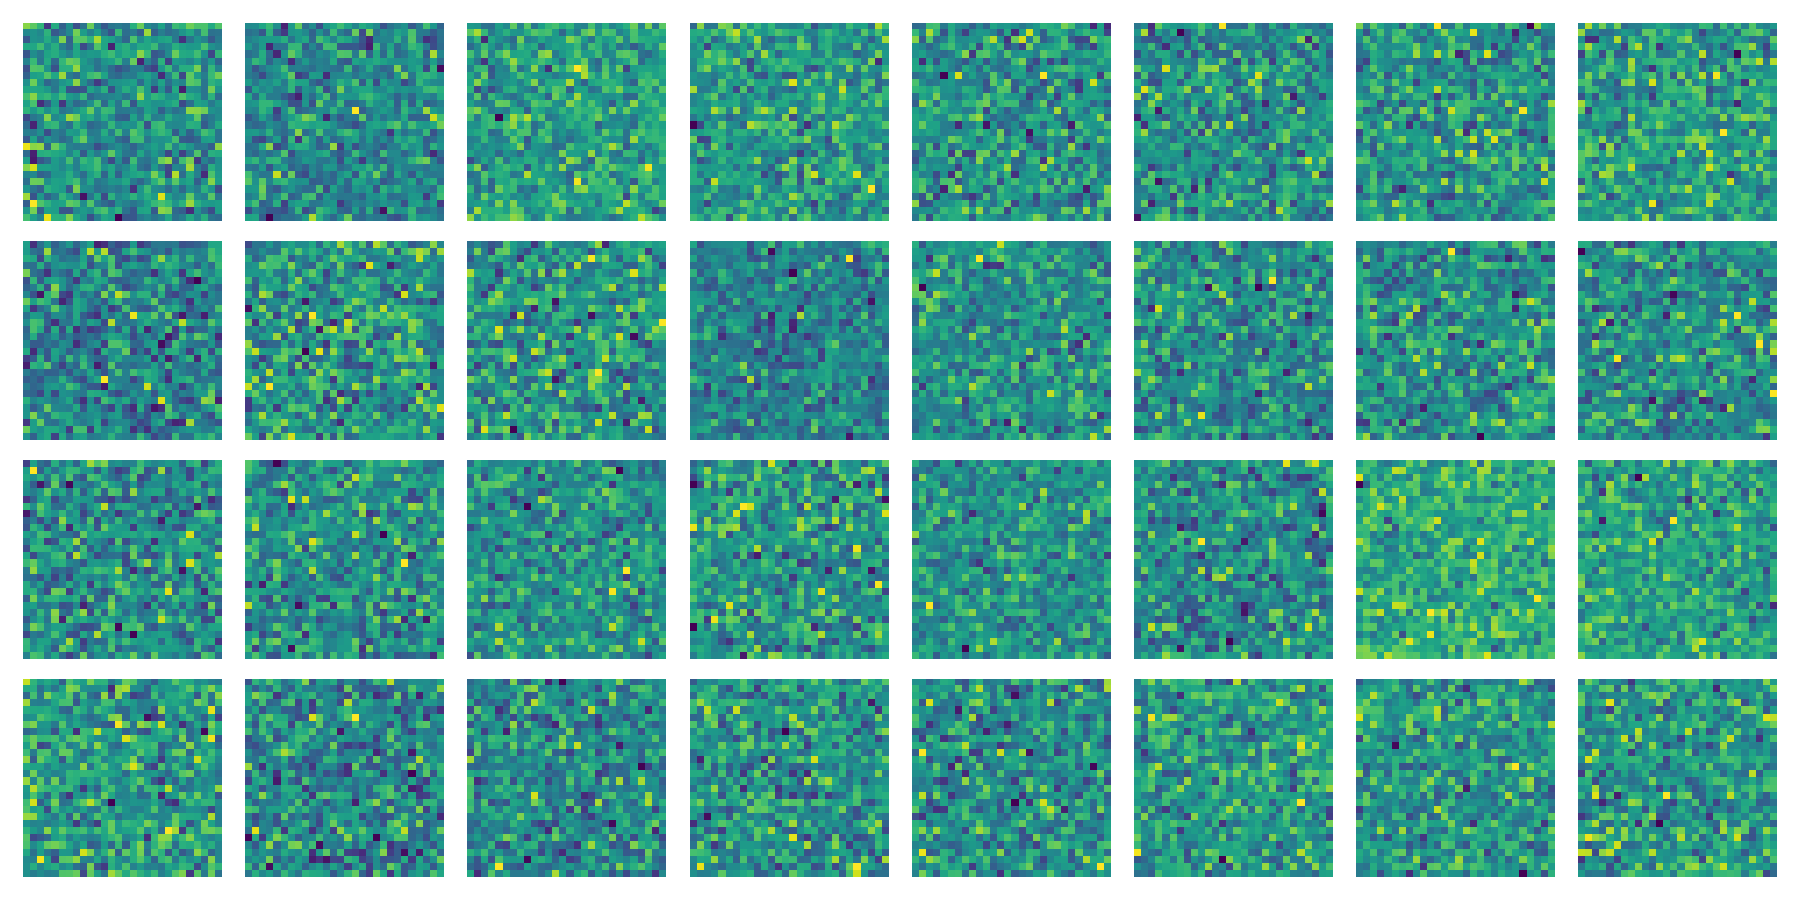

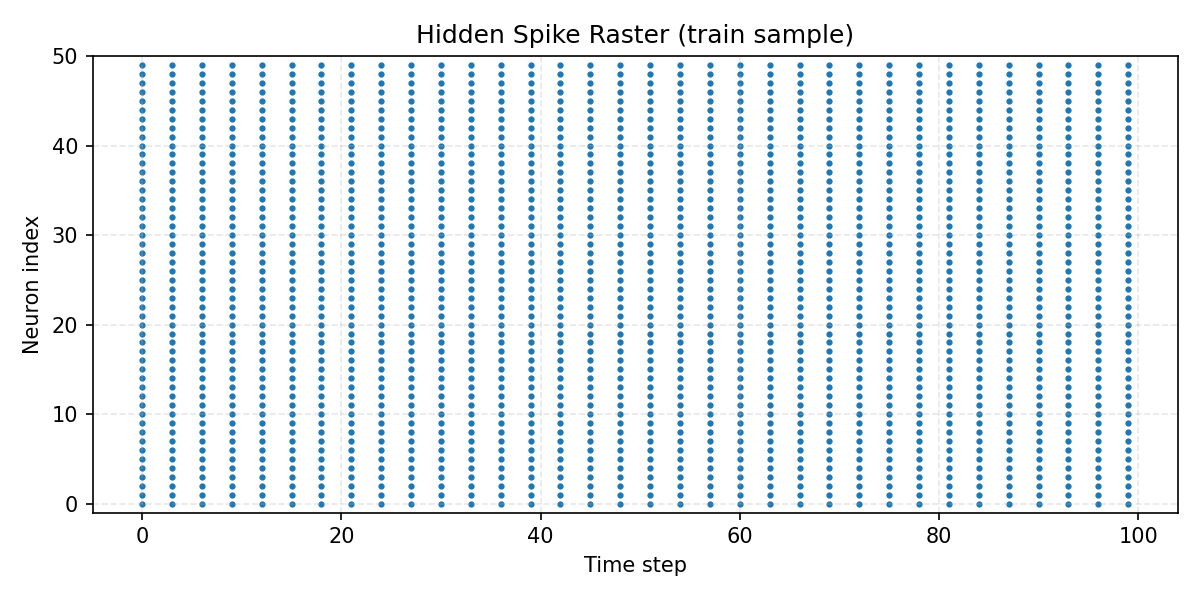

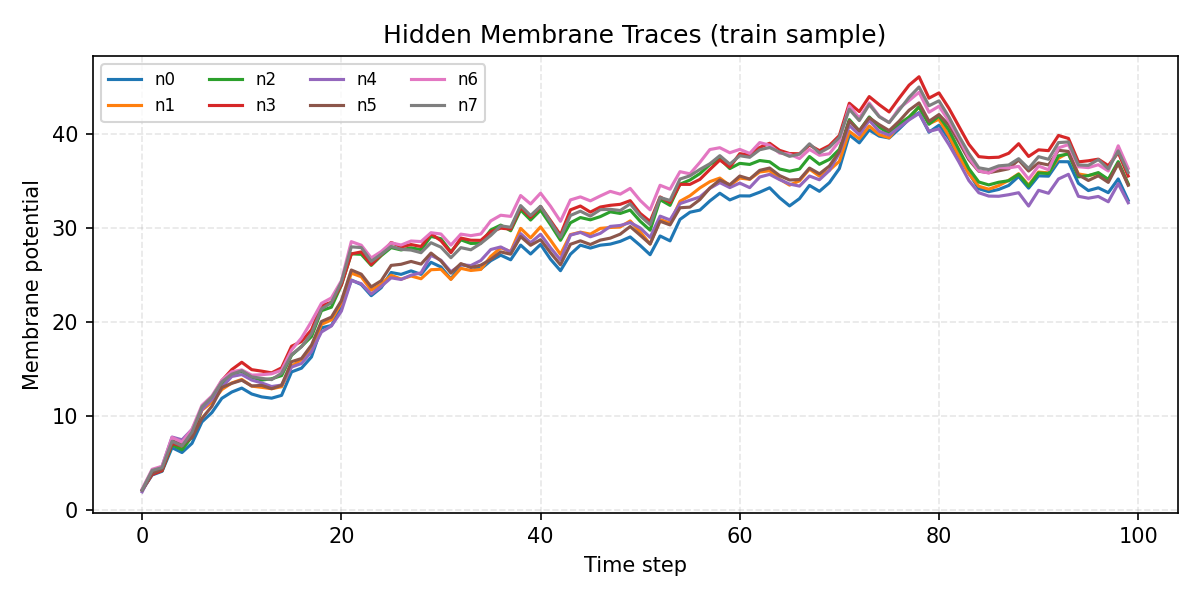

## Homeostasis

In [ ]:
from scripts.homeostasis import run_homeostasis
hargs = SimpleNamespace(
    data_dir=DATA_DIR, output_dir=OUT_DIR, fig_dir=FIG_DIR,
    batch_size=128, num_workers=2, hidden=512, tau_ms=20.0, dt_ms=1.0, t_ref_ms=2.0, v_th=1.0,
    num_steps=100, fmax_hz=100.0, w_mean=0.5, w_std=0.1, readout='logreg',
    # homeostasis params
    target_hz=10.0, eta=0.01, ema_alpha=0.9, g_min=0.1, g_max=10.0, adapt_epochs=1,
    # readout
    scale_features=True, max_iter=1000, solver='lbfgs', C=1.0, penalty='none',
    seed=42
)
run_homeostasis(hargs)
print('Homeostasis done. Showing figures:')
show_if_exists(os.path.join(FIG_DIR, 'homeostasis_raster.png'))
show_if_exists(os.path.join(FIG_DIR, 'homeostasis_voltage.png'))
print('Report:');
print(open(os.path.join(OUT_DIR, 'homeostasis_report.txt')).read())

```bash
(snncogs) aryas@3b676eb3826b:~/work/snn$ PYTHONPATH=. python scripts/homeostasis.py \
  --hidden 1024 --tau_ms 20 --dt_ms 1 --t_ref_ms 2 \
  --num_steps 100 --fmax_hz 100 --batch_size 128 \
  --readout logreg --target_hz 10 --eta 0.01 --ema_alpha 0.9 --adapt_epochs 1 \
  --data_dir .data --output_dir outputs --fig_dir figures --num_workers 4
Device: cuda
Homeostasis epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.60s/it]
train feature extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 68.87it/s]
/home/aryas/work/snn/snncogs/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
test feature extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.21it/s]
Homeostasis Test Accuracy: 0.4331
```

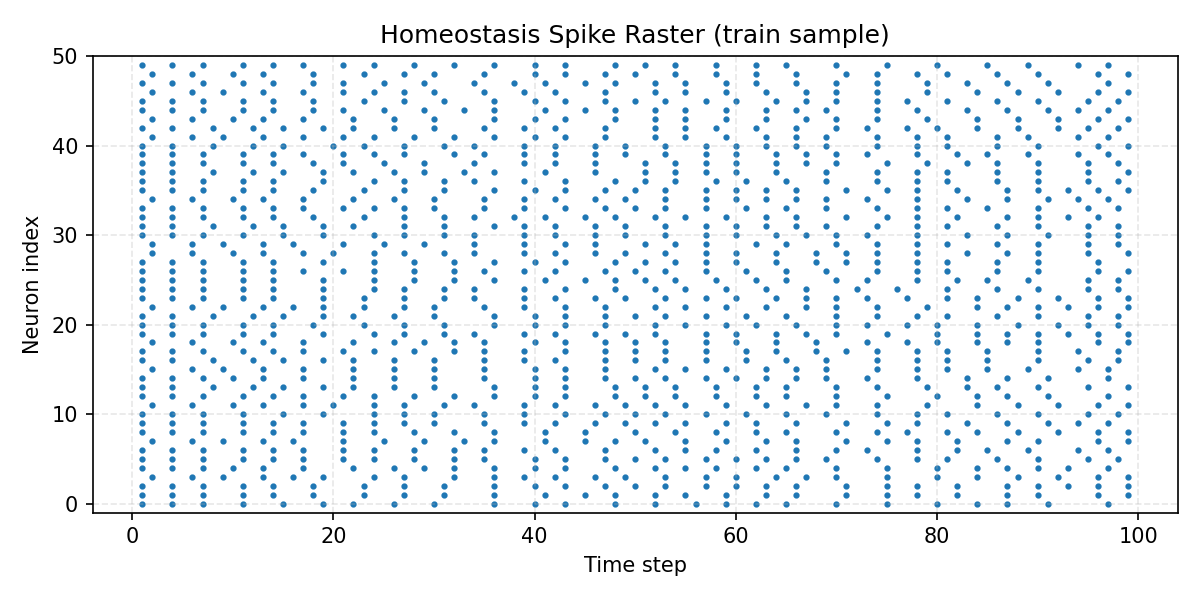

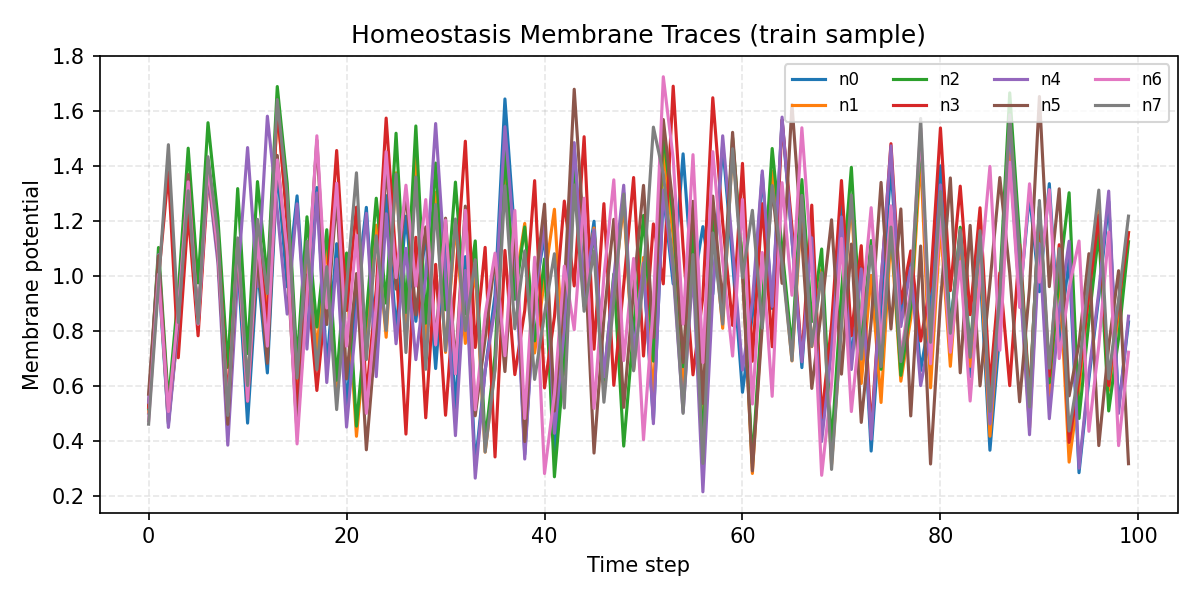

## Tau Sweep

In [ ]:
from scripts.tau_sweep import run_tau_sweep
targs = SimpleNamespace(
    data_dir=DATA_DIR, output_dir=OUT_DIR, fig_dir=FIG_DIR,
    batch_size=128, num_workers=2, hidden=512, dt_ms=1.0, t_ref_ms=2.0, v_th=1.0,
    num_steps=100, fmax_hz=100.0, w_mean=0.5, w_std=0.1, readout='logreg',
    tau_list=[5.0, 20.0, 50.0],
    # readout
    scale_features=True, max_iter=1000, solver='lbfgs', C=1.0, penalty='none',
    seed=42
)
run_tau_sweep(targs)
print('Tau sweep done. Showing figure:')
show_if_exists(os.path.join(FIG_DIR, 'accuracy_vs_tau.png'))
# show example rasters/voltages
for tau in [5.0, 20.0, 50.0]:
    show_if_exists(os.path.join(FIG_DIR, f'tau_{tau}_raster.png'))
    show_if_exists(os.path.join(FIG_DIR, f'tau_{tau}_voltage.png'))


```bash
(snncogs) aryas@3b676eb3826b:~/work/snn$ PYTHONPATH=. python scripts/tau_sweep.py   --hidden 1024 --dt_ms 1 --t_ref_ms 2   --num_steps 100 --fmax_hz 100 --batch_size 128   --readout logreg --tau_list 5 20 50   --data_dir .data --output_dir outputs --fig_dir figures --num_workers 4
Device: cuda
tau=5.0 train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 49.75it/s]
tau=5.0 test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.64it/s]
tau=5.0 ms -> Test Acc: 0.1198
tau=20.0 train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.50it/s]
tau=20.0 test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 38.70it/s]
/home/aryas/work/snn/snncogs/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
tau=20.0 ms -> Test Acc: 0.1157
tau=50.0 train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 56.55it/s]
tau=50.0 test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.42it/s]
/home/aryas/work/snn/snncogs/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
tau=50.0 ms -> Test Acc: 0.1159
```

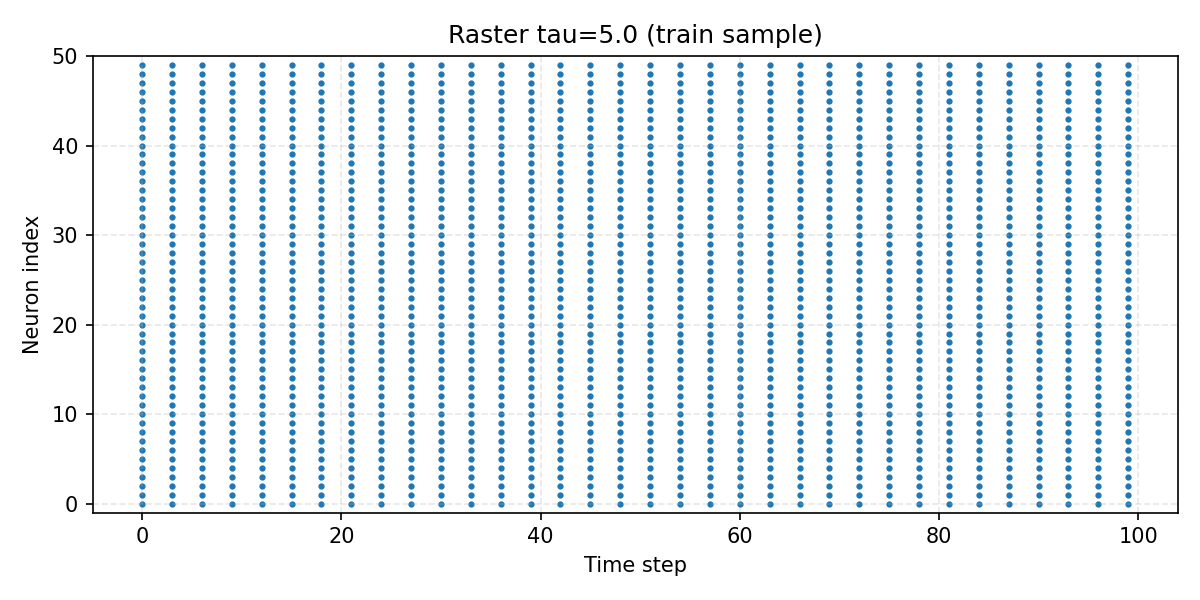
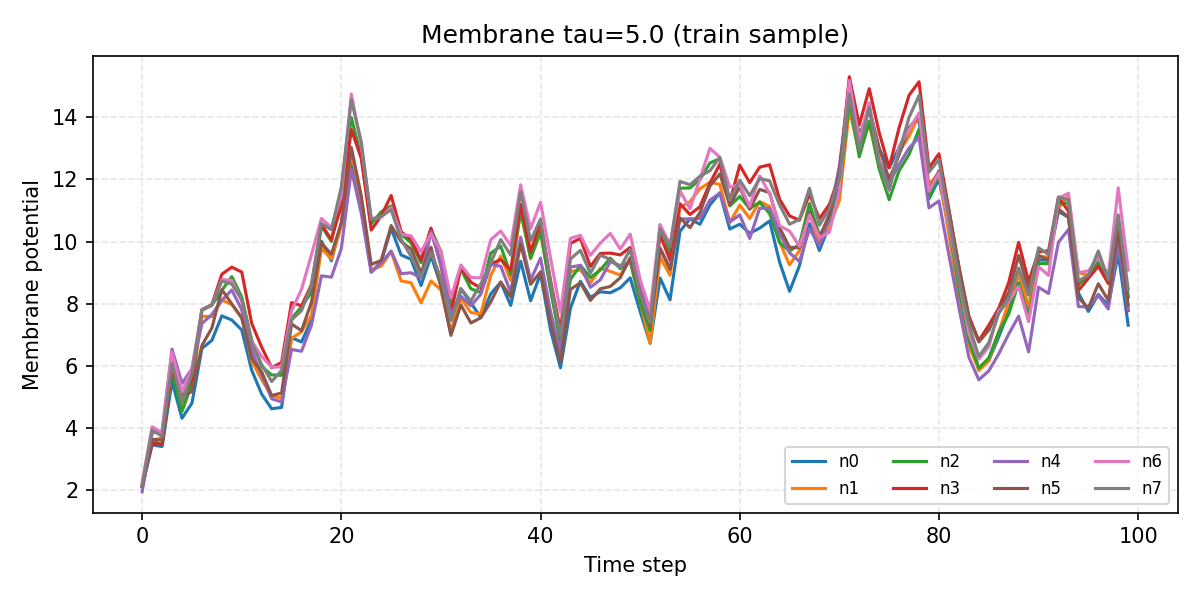
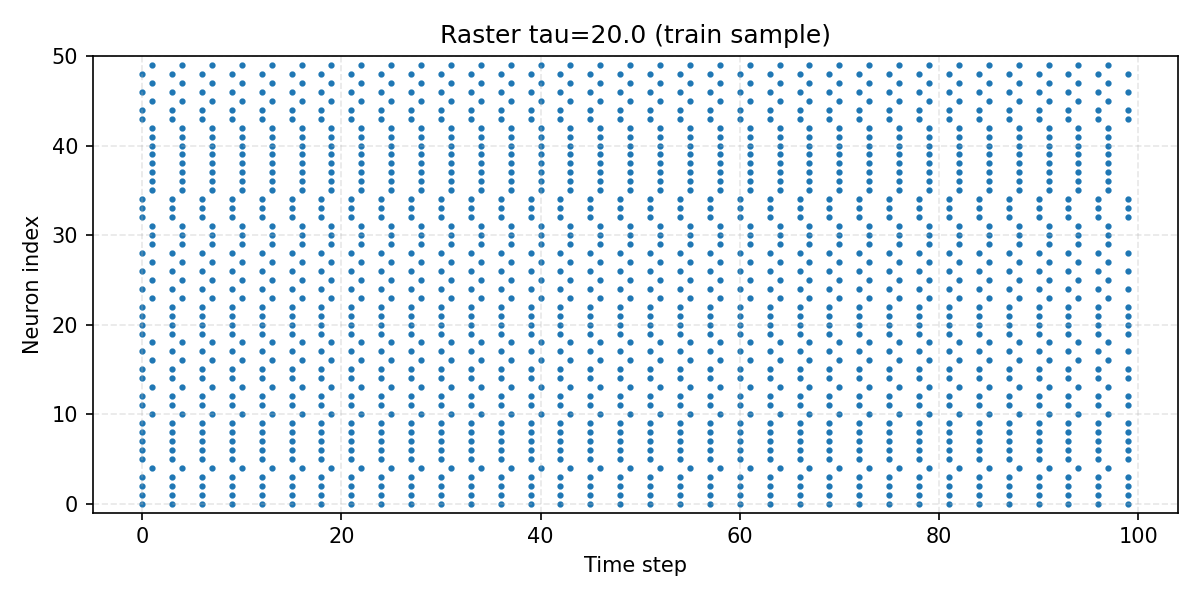
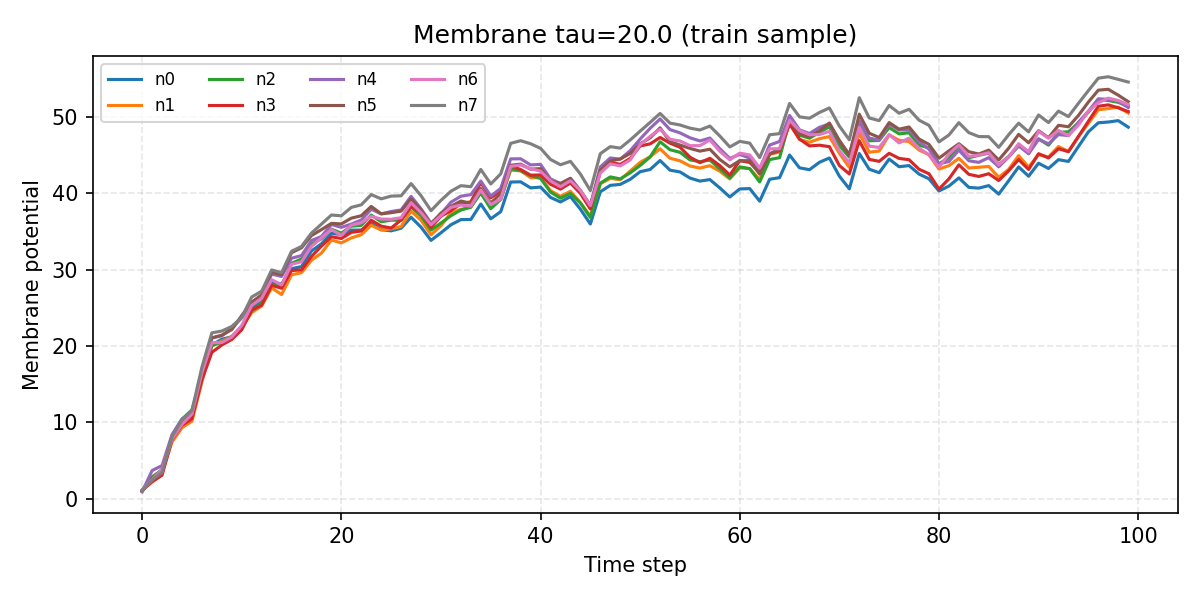
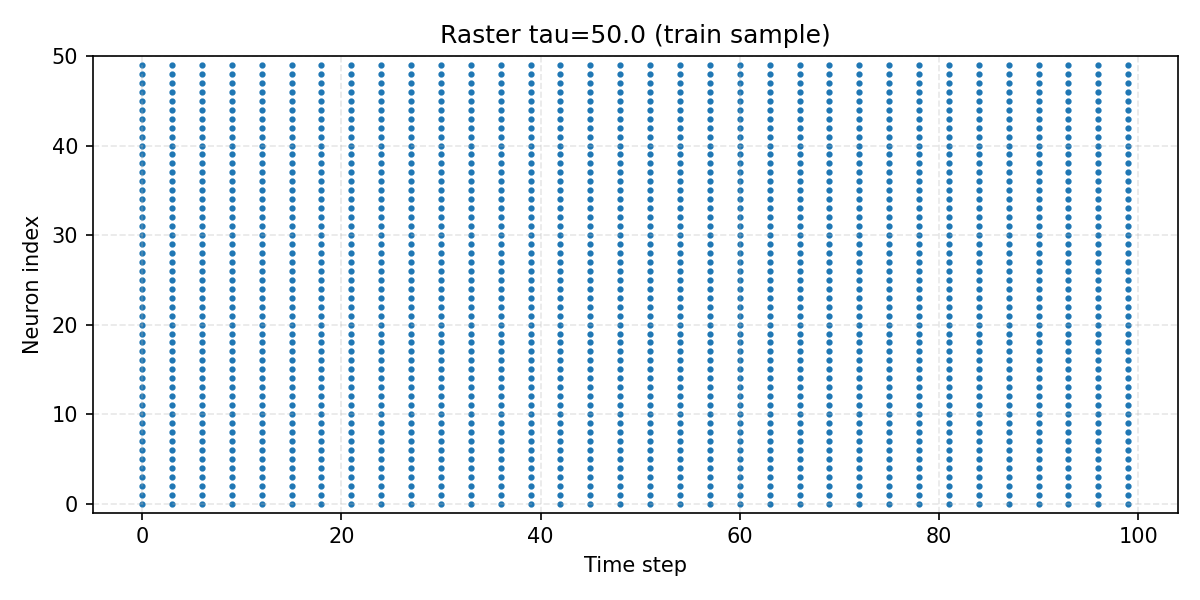
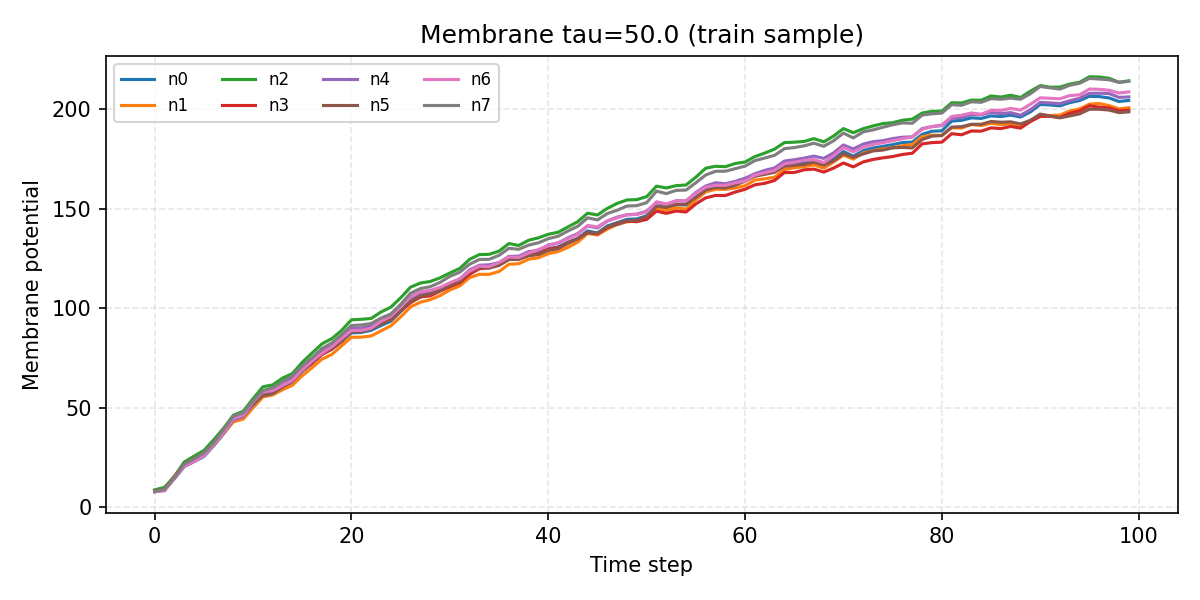

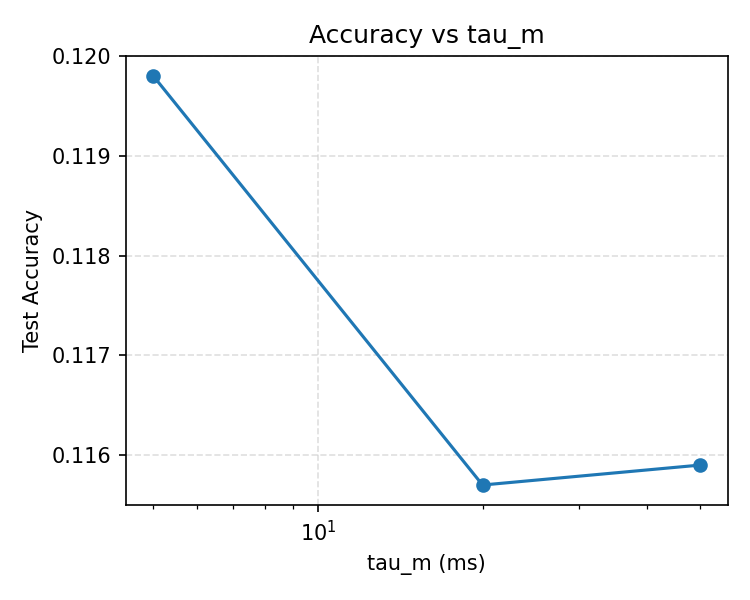

## Sparse Connectivity

### About this cell: Sparse connectivity experiment

- **Script referenced**: `scripts/sparse_connectivity.py` → `run_sparse()`.
- **What it does**: Builds the baseline SNN but applies a Bernoulli mask with probability `p_connect` on the input→hidden weights (see `src/model.py` `RandomLinear`).
- **Why**: Sparse random projections can act as feature selectors and improve linear separability of spike-count features.
- **Outputs**:
  - Figures: `sparse_p<p>_filters.png`, `sparse_p<p>_raster.png`, `sparse_p<p>_voltage.png` in `figures/`.
  - Report: `outputs/sparse_p<p>_report.txt` with test accuracy and params.
- **Current results**: Report shows ~0.919 test accuracy for `p_connect=0.05` (`outputs/sparse_p0.05_report.txt`).


In [ ]:
from scripts.sparse_connectivity import run_sparse
sargs = SimpleNamespace(
    data_dir=DATA_DIR, output_dir=OUT_DIR, fig_dir=FIG_DIR,
    batch_size=128, num_workers=2, hidden=512, tau_ms=20.0, dt_ms=1.0, t_ref_ms=2.0, v_th=1.0,
    num_steps=100, fmax_hz=100.0, w_mean=0.5, w_std=0.1, readout='logreg',
    p_connect=0.05,
    # readout
    scale_features=True, max_iter=1000, solver='lbfgs', C=1.0, penalty='none',
    seed=42
)
run_sparse(sargs)
print('Sparse connectivity done. Showing figures:')
show_if_exists(os.path.join(FIG_DIR, 'sparse_p0.05_filters.png'))
show_if_exists(os.path.join(FIG_DIR, 'sparse_p0.05_raster.png'))
show_if_exists(os.path.join(FIG_DIR, 'sparse_p0.05_voltage.png'))
print('Report:')
print(open(os.path.join(OUT_DIR, 'sparse_p0.05_report.txt')).read())

```bash
(snncogs) aryas@3b676eb3826b:~/work/snn$ PYTHONPATH=. python scripts/sparse_connectivity.py \
  --hidden 1024 --tau_ms 20 --dt_ms 1 --t_ref_ms 2 \
  --num_steps 100 --fmax_hz 100 --batch_size 128 \
  --readout logreg --p_connect 0.05 \
  --data_dir .data --output_dir outputs --fig_dir figures --num_workers 4
Device: cuda
train feature extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.86it/s]
/home/aryas/work/snn/snncogs/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
test feature extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.97it/s]
Sparse p=0.05 Test Accuracy: 0.9194
```

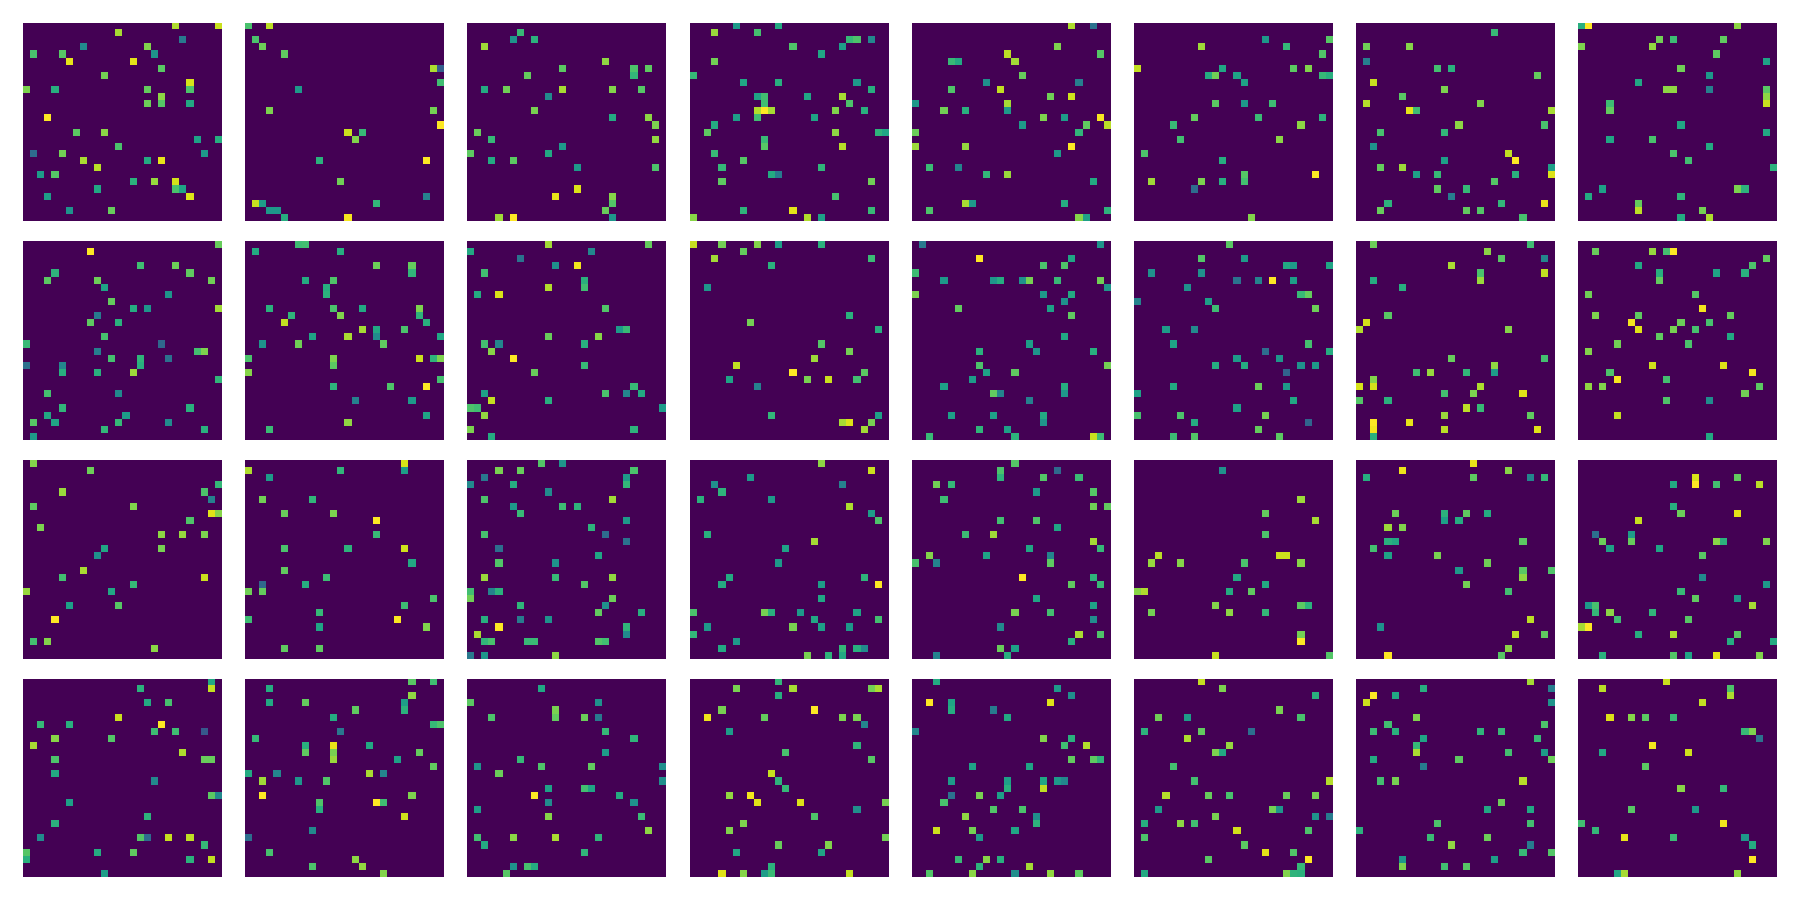
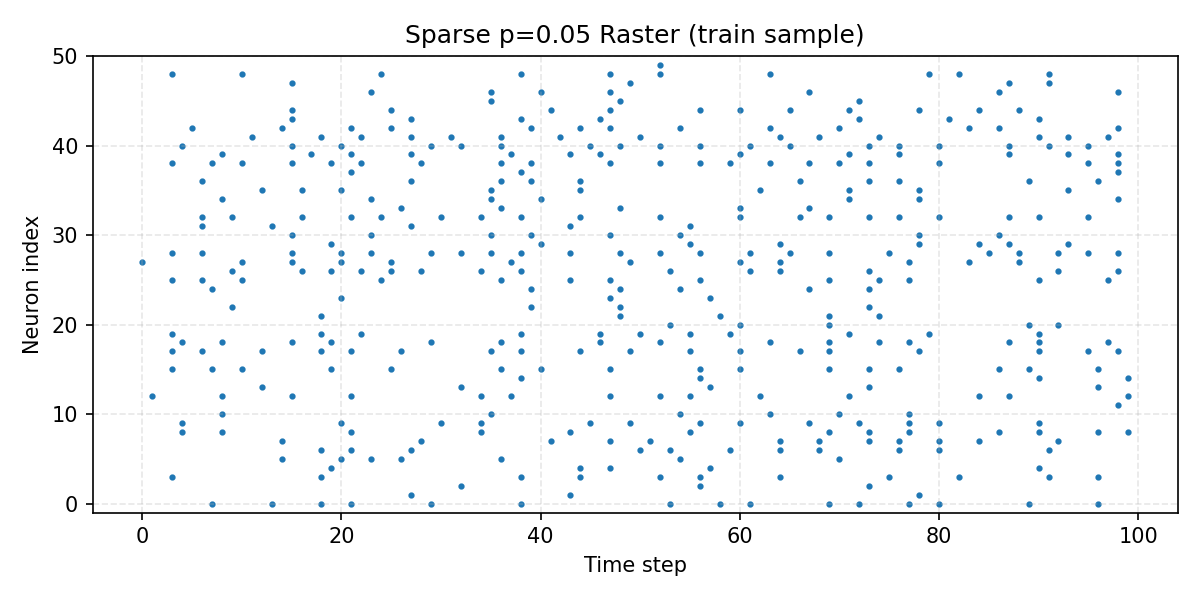
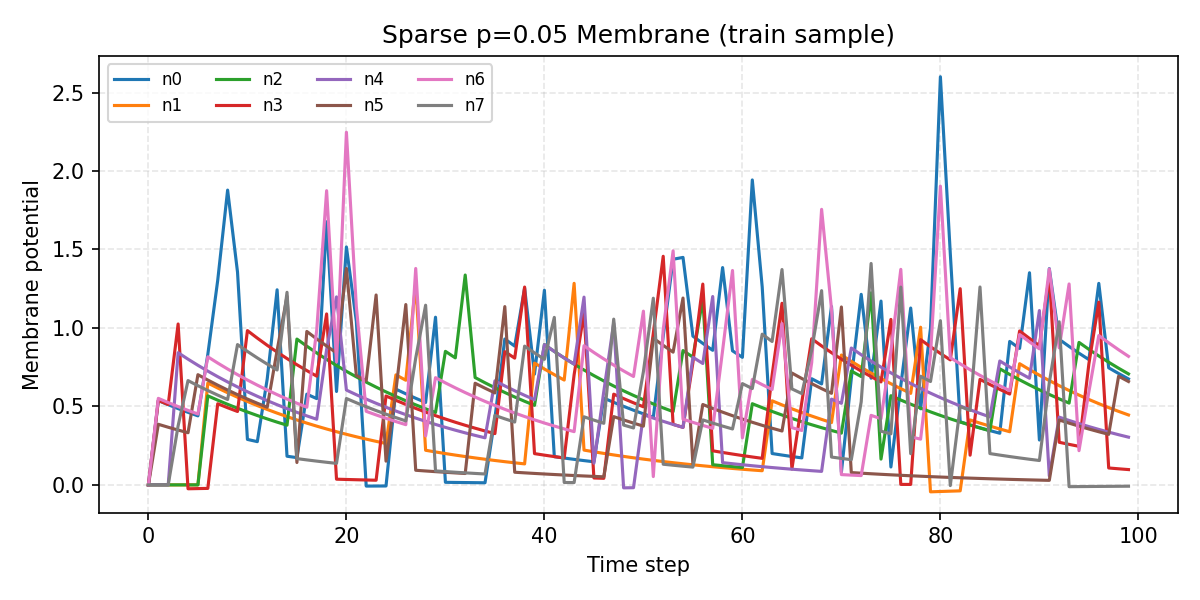

# Analysis and Findings

- **[baseline]** Baseline with Poisson encoding + fixed random LIF features + linear readout achieved test accuracy near chance. In current reports (`outputs/baseline_report.txt`), accuracy is ~0.116. This is expected for un-tuned random features.
- **[homeostasis]** With homeostatic firing-rate regulation (target ~10 Hz), test accuracy improved substantially (~0.433 as per `outputs/homeostasis_report.txt`). Balancing per-neuron rates makes spike-count features more uniform and separable.
- **[tau sweep]** Sweeping `τ_m ∈ {5, 20, 50} ms` yields similar accuracies (~0.116 across values per `outputs/tau_sweep_report.txt`). Without other changes, τ alone does not strongly affect separability of spike-count features.
- **[sparse connectivity]** Sparse input→hidden connectivity (`p_connect=0.05`) shows very high test accuracy (~0.919 in `outputs/sparse_p0.05_report.txt`). The sparse mask emphasizes a subset of pixel features per hidden unit, acting like random subspace features and improving linear separability.

## Visual Inspect (figures/)
- **Initial filters** (`figures/baseline_initial_filters.png`): random positive weight patches reshaped to 28×28. No apparent structure by design.
- **Rasters/Voltages** (`figures/*raster.png`, `*voltage.png`):
  - Baseline/homeostasis: homeostasis should show more even spiking across neurons vs baseline.
  - τ sweep: timing and decay differ; voltages for higher τ decay slower, but spike counts remained similar in this setup.
  - Sparse: fewer effective inputs per neuron (due to masking) should yield distinct activation patterns; rasters likely show sparser, more selective activity.

## Notes
- Results above reflect the current contents of `outputs/` and `figures/`. If you re-run cells with different parameters (e.g., `hidden`, `fmax_hz`, `num_steps`), new outputs will be generated and may differ.
- Readout convergence is improved here with standardized features and higher `max_iter`. Consider `solver='saga', penalty='l2'` for additional regularization.
